In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define dataset paths
train_dir = 'dataset_2/Augmented_Train'
test_dir = 'dataset/Test'

# Get class names (folder names)
class_names = sorted(os.listdir(train_dir))
num_classes = len(class_names)

# Create label mapping
label_map = {i: class_name for i, class_name in enumerate(class_names)}
print("Class mapping:")
for i, class_name in label_map.items():
    print(f"{i}: {class_name}")

# Create DataFrames for train and test
def create_dataframe(directory):
    data = []
    for class_label, class_name in enumerate(class_names):
        class_dir = os.path.join(directory, class_name)
        for filename in os.listdir(class_dir):
            if filename.endswith('.jpg'):
                image_path = os.path.join(class_dir, filename)
                data.append({'image_path': image_path, 'label': class_label})
    return pd.DataFrame(data)

train_df = create_dataframe(train_dir)
test_df = create_dataframe(test_dir)

# Combine for EDA
df = pd.concat([train_df, test_df], ignore_index=True)

print(f"\nTotal images: {len(df)}")
print(f"Number of classes: {num_classes}")
df.head()

Class mapping:
0: actinic keratosis
1: basal cell carcinoma
2: dermatofibroma
3: melanoma
4: nevus
5: pigmented benign keratosis
6: seborrheic keratosis
7: squamous cell carcinoma
8: vascular lesion

Total images: 19417
Number of classes: 9


,image_path,label
0,dataset_2/Augmented_Train/actinic keratosis/au...,0
1,dataset_2/Augmented_Train/actinic keratosis/au...,0
2,dataset_2/Augmented_Train/actinic keratosis/au...,0
3,dataset_2/Augmented_Train/actinic keratosis/au...,0
4,dataset_2/Augmented_Train/actinic keratosis/au...,0


Dataset Summary
------------------------------------------------------------
Class Label     Class Name                     Count     
------------------------------------------------------------
0               actinic keratosis              2068      
1               basal cell carcinoma           2272      
2               dermatofibroma                 2106      
3               melanoma                       2206      
4               nevus                          2158      
5               pigmented benign keratosis     2326      
6               seborrheic keratosis           2005      
7               squamous cell carcinoma        2188      
8               vascular lesion                2088      
------------------------------------------------------------
Total                                         19417     


/var/folders/y1/h79s3r65315g9wv00772tp6m0000gn/T/ipykernel_20559/1547047213.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, order=range(num_classes), palette='viridis')


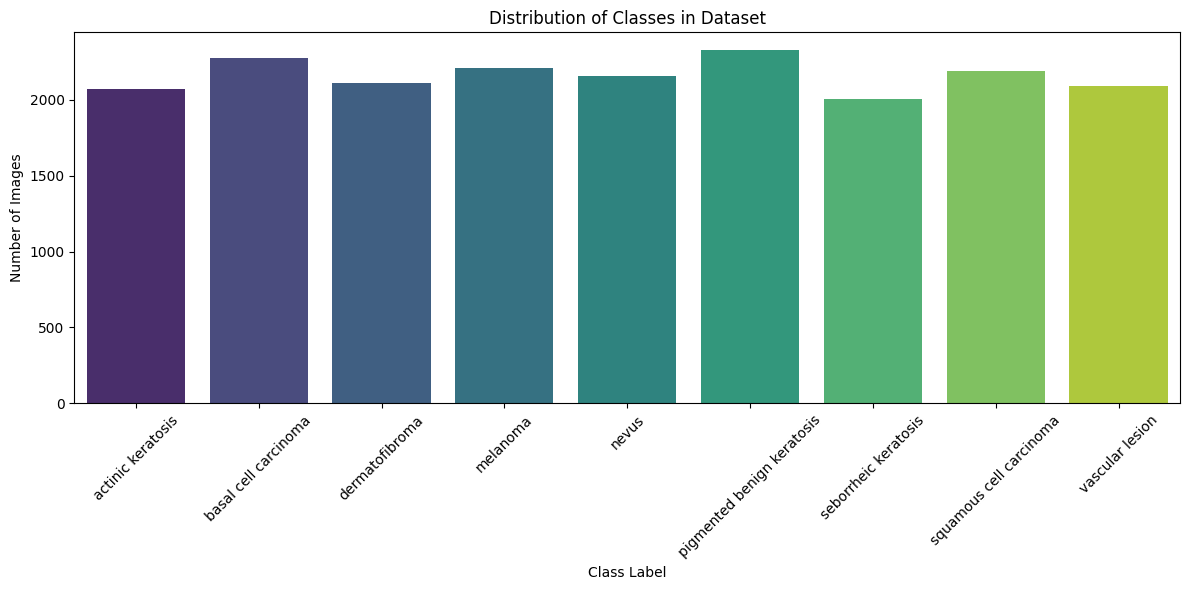

In [3]:
class_counts = df['label'].value_counts().sort_index()

# Print the number of images in each class
print("Dataset Summary")
print("-" * 60)
print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
print("-" * 60)
for class_label, class_name in label_map.items():
    count = class_counts[class_label]
    print(f"{class_label:<15} {class_name:<30} {count:<10}")
print("-" * 60)
print(f"{'Total':<45} {sum(class_counts):<10}")

# Plot class distribution
plt.figure(figsize=(12, 6))
sns.countplot(x='label', data=df, order=range(num_classes), palette='viridis')
plt.title('Distribution of Classes in Dataset')
plt.xlabel('Class Label')
plt.ylabel('Number of Images')
plt.xticks(ticks=range(num_classes), labels=[label_map[i] for i in range(num_classes)], rotation=45)
plt.tight_layout()
plt.show()

In [4]:
from PIL import Image
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import resample

# Define image size
IMG_HEIGHT = 75
IMG_WIDTH = 100

# Function to load and resize images
def load_and_resize_image(image_path):
    try:
        img = Image.open(image_path)
        img = img.resize((IMG_WIDTH, IMG_HEIGHT))
        return np.array(img)
    except Exception as e:
        print(f"Error loading {image_path}: {e}")
        return None

# Load all images
print("Loading images...")
df['image'] = df['image_path'].apply(load_and_resize_image)
df = df.dropna(subset=['image'])  # Remove failed loads
print(f"Successfully loaded {len(df)} images")

# Find the class with the maximum number of samples
max_class_size = df['label'].value_counts().max()
print(f"Majority class size: {max_class_size}")

# Create a balanced dataset by oversampling minority classes
balanced_dfs = []
for class_label in df['label'].unique():
    class_df = df[df['label'] == class_label]
    if len(class_df) < max_class_size:
        # Oversample minority classes
        oversampled_df = resample(class_df, 
                                 replace=True, 
                                 n_samples=max_class_size,
                                 random_state=42)
        balanced_dfs.append(oversampled_df)
    else:
        balanced_dfs.append(class_df)

# Combine balanced dataframes
balanced_df = pd.concat(balanced_dfs)
print(f"Balanced dataset size: {len(balanced_df)}")

# Verify new class distribution
print("\nBalanced Class Distribution:")
print(balanced_df['label'].value_counts().sort_index())

# Normalize pixel values
balanced_df['image'] = balanced_df['image'] / 255.0

# Create data augmentation generator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

Loading images...
Successfully loaded 19417 images
Majority class size: 2326
Balanced dataset size: 20934

Balanced Class Distribution:
label
0    2326
1    2326
2    2326
3    2326
4    2326
5    2326
6    2326
7    2326
8    2326
Name: count, dtype: int64


In [5]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Prepare data for splitting
x = np.stack(balanced_df['image'].values)
y = balanced_df['label'].values

# Convert labels to one-hot encoding
y_onehot = tf.keras.utils.to_categorical(y, num_classes=num_classes)

# Split into train (70%), validation (15%), and test (15%)
x_train, x_temp, y_train, y_temp = train_test_split(
    x, y_onehot, 
    test_size=0.3, 
    stratify=y, 
    random_state=42
)

x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, 
    test_size=0.5, 
    stratify=np.argmax(y_temp, axis=1), 
    random_state=42
)

# Print split information
print(f"Training set: {x_train.shape} - {len(y_train)} samples")
print(f"Validation set: {x_val.shape} - {len(y_val)} samples")
print(f"Test set: {x_test.shape} - {len(y_test)} samples")

# Verify class distribution in each split
def print_class_distribution(y_data, split_name):
    y_labels = np.argmax(y_data, axis=1)
    unique, counts = np.unique(y_labels, return_counts=True)
    print(f"\n{split_name} Class Distribution:")
    for label, count in zip(unique, counts):
        print(f"  Class {label} ({label_map[label]}): {count} samples")

print_class_distribution(y_train, "Training")
print_class_distribution(y_val, "Validation")
print_class_distribution(y_test, "Test")

Training set: (14653, 75, 100, 3) - 14653 samples
Validation set: (3140, 75, 100, 3) - 3140 samples
Test set: (3141, 75, 100, 3) - 3141 samples

Training Class Distribution:
  Class 0 (actinic keratosis): 1628 samples
  Class 1 (basal cell carcinoma): 1628 samples
  Class 2 (dermatofibroma): 1628 samples
  Class 3 (melanoma): 1628 samples
  Class 4 (nevus): 1628 samples
  Class 5 (pigmented benign keratosis): 1628 samples
  Class 6 (seborrheic keratosis): 1628 samples
  Class 7 (squamous cell carcinoma): 1629 samples
  Class 8 (vascular lesion): 1628 samples

Validation Class Distribution:
  Class 0 (actinic keratosis): 349 samples
  Class 1 (basal cell carcinoma): 349 samples
  Class 2 (dermatofibroma): 349 samples
  Class 3 (melanoma): 349 samples
  Class 4 (nevus): 349 samples
  Class 5 (pigmented benign keratosis): 349 samples
  Class 6 (seborrheic keratosis): 349 samples
  Class 7 (squamous cell carcinoma): 348 samples
  Class 8 (vascular lesion): 349 samples

Test Class Distribut

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Define the model architecture
def create_model(input_shape=(75, 100, 3), num_classes=9):
    model = Sequential([
        # First convolutional block
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        # Second convolutional block
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        # Third convolutional block
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        # Fourth convolutional block
        Conv2D(256, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        
        # Flatten and dense layers
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    return model

# Create the model
model = create_model(input_shape=(75, 100, 3), num_classes=num_classes)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model.summary()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 73, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 73, 98, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 36, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 34, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 34, 47, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 17, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 15, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 15, 21, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 7, 10, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 5, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 5, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,444,041 (5.51 MB)

 Trainable params: 1,443,081 (5.50 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/30
458/458 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.3574 - loss: 2.2057
Epoch 1: val_accuracy improved from -inf to 0.27389, saving model to best_skin_cancer_model.h5


458/458 ━━━━━━━━━━━━━━━━━━━━ 33s 67ms/step - accuracy: 0.3575 - loss: 2.2047 - val_accuracy: 0.2739 - val_loss: 2.1380 - learning_rate: 0.0010
Epoch 2/30
458/458 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.5196 - loss: 1.2899
Epoch 2: val_accuracy improved from 0.27389 to 0.46115, saving model to best_skin_cancer_model.h5


458/458 ━━━━━━━━━━━━━━━━━━━━ 38s 82ms/step - accuracy: 0.5196 - loss: 1.2898 - val_accuracy: 0.4611 - val_loss: 1.4219 - learning_rate: 0.0010
Epoch 3/30
458/458 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.5753 - loss: 1.1203
Epoch 3: val_accuracy improved from 0.46115 to 0.48439, saving model to best_skin_cancer_model.h5


458/458 ━━━━━━━━━━━━━━━━━━━━ 58s 126ms/step - accuracy: 0.5753 - loss: 1.1202 - val_accuracy: 0.4844 - val_loss: 1.7042 - learning_rate: 0.0010
Epoch 4/30
458/458 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.6400 - loss: 0.9634
Epoch 4: val_accuracy did not improve from 0.48439
458/458 ━━━━━━━━━━━━━━━━━━━━ 60s 130ms/step - accuracy: 0.6400 - loss: 0.9635 - val_accuracy: 0.4541 - val_loss: 1.4707 - learning_rate: 0.0010
Epoch 5/30
458/458 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.6693 - loss: 0.8759
Epoch 5: val_accuracy improved from 0.48439 to 0.53662, saving model to best_skin_cancer_model.h5


458/458 ━━━━━━━━━━━━━━━━━━━━ 61s 132ms/step - accuracy: 0.6694 - loss: 0.8758 - val_accuracy: 0.5366 - val_loss: 1.3265 - learning_rate: 0.0010
Epoch 6/30
458/458 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.7142 - loss: 0.7521
Epoch 6: val_accuracy did not improve from 0.53662
458/458 ━━━━━━━━━━━━━━━━━━━━ 61s 133ms/step - accuracy: 0.7142 - loss: 0.7521 - val_accuracy: 0.2596 - val_loss: 4.4558 - learning_rate: 0.0010
Epoch 7/30
458/458 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.7472 - loss: 0.6617
Epoch 7: val_accuracy did not improve from 0.53662
458/458 ━━━━━━━━━━━━━━━━━━━━ 60s 131ms/step - accuracy: 0.7472 - loss: 0.6617 - val_accuracy: 0.5258 - val_loss: 1.4379 - learning_rate: 0.0010
Epoch 8/30
458/458 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.7872 - loss: 0.5661
Epoch 8: val_accuracy improved from 0.53662 to 0.58662, saving model to best_skin_cancer_model.h5


458/458 ━━━━━━━━━━━━━━━━━━━━ 61s 133ms/step - accuracy: 0.7872 - loss: 0.5661 - val_accuracy: 0.5866 - val_loss: 1.2514 - learning_rate: 0.0010
Epoch 9/30
458/458 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.8188 - loss: 0.4753
Epoch 9: val_accuracy improved from 0.58662 to 0.60987, saving model to best_skin_cancer_model.h5


458/458 ━━━━━━━━━━━━━━━━━━━━ 63s 137ms/step - accuracy: 0.8188 - loss: 0.4754 - val_accuracy: 0.6099 - val_loss: 1.2754 - learning_rate: 0.0010
Epoch 10/30
458/458 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.8364 - loss: 0.4259
Epoch 10: val_accuracy improved from 0.60987 to 0.77452, saving model to best_skin_cancer_model.h5


458/458 ━━━━━━━━━━━━━━━━━━━━ 64s 140ms/step - accuracy: 0.8364 - loss: 0.4259 - val_accuracy: 0.7745 - val_loss: 0.6730 - learning_rate: 0.0010
Epoch 11/30
458/458 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.8638 - loss: 0.3719
Epoch 11: val_accuracy did not improve from 0.77452
458/458 ━━━━━━━━━━━━━━━━━━━━ 70s 154ms/step - accuracy: 0.8638 - loss: 0.3720 - val_accuracy: 0.7223 - val_loss: 0.8891 - learning_rate: 0.0010
Epoch 12/30
458/458 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.8788 - loss: 0.3219
Epoch 12: val_accuracy did not improve from 0.77452
458/458 ━━━━━━━━━━━━━━━━━━━━ 73s 160ms/step - accuracy: 0.8788 - loss: 0.3219 - val_accuracy: 0.6465 - val_loss: 1.4598 - learning_rate: 0.0010
Epoch 13/30
458/458 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.8980 - loss: 0.2821
Epoch 13: val_accuracy did not improve from 0.77452

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
458/458 ━━━━━━━━━━━━━━━━━━━━ 72s 158ms/step - accuracy: 0.8980 - l

458/458 ━━━━━━━━━━━━━━━━━━━━ 73s 159ms/step - accuracy: 0.9296 - loss: 0.2009 - val_accuracy: 0.8545 - val_loss: 0.4910 - learning_rate: 2.0000e-04
Epoch 15/30
458/458 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.9605 - loss: 0.1209
Epoch 15: val_accuracy did not improve from 0.85446
458/458 ━━━━━━━━━━━━━━━━━━━━ 74s 162ms/step - accuracy: 0.9605 - loss: 0.1209 - val_accuracy: 0.8210 - val_loss: 0.6190 - learning_rate: 2.0000e-04
Epoch 16/30
458/458 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9683 - loss: 0.0907
Epoch 16: val_accuracy improved from 0.85446 to 0.86178, saving model to best_skin_cancer_model.h5


458/458 ━━━━━━━━━━━━━━━━━━━━ 74s 161ms/step - accuracy: 0.9683 - loss: 0.0907 - val_accuracy: 0.8618 - val_loss: 0.5072 - learning_rate: 2.0000e-04
Epoch 17/30
458/458 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.9737 - loss: 0.0788
Epoch 17: val_accuracy did not improve from 0.86178

Epoch 17: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
458/458 ━━━━━━━━━━━━━━━━━━━━ 71s 155ms/step - accuracy: 0.9737 - loss: 0.0788 - val_accuracy: 0.8554 - val_loss: 0.5803 - learning_rate: 2.0000e-04
Epoch 18/30
458/458 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.9784 - loss: 0.0630
Epoch 18: val_accuracy improved from 0.86178 to 0.88439, saving model to best_skin_cancer_model.h5


458/458 ━━━━━━━━━━━━━━━━━━━━ 73s 160ms/step - accuracy: 0.9784 - loss: 0.0630 - val_accuracy: 0.8844 - val_loss: 0.4733 - learning_rate: 4.0000e-05
Epoch 19/30
458/458 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.9817 - loss: 0.0539
Epoch 19: val_accuracy improved from 0.88439 to 0.88631, saving model to best_skin_cancer_model.h5


458/458 ━━━━━━━━━━━━━━━━━━━━ 73s 158ms/step - accuracy: 0.9817 - loss: 0.0539 - val_accuracy: 0.8863 - val_loss: 0.4664 - learning_rate: 4.0000e-05
Epoch 20/30
458/458 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9821 - loss: 0.0544
Epoch 20: val_accuracy did not improve from 0.88631
458/458 ━━━━━━━━━━━━━━━━━━━━ 74s 162ms/step - accuracy: 0.9821 - loss: 0.0544 - val_accuracy: 0.8834 - val_loss: 0.4713 - learning_rate: 4.0000e-05
Epoch 21/30
458/458 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9848 - loss: 0.0473
Epoch 21: val_accuracy did not improve from 0.88631
458/458 ━━━━━━━━━━━━━━━━━━━━ 74s 161ms/step - accuracy: 0.9848 - loss: 0.0473 - val_accuracy: 0.8841 - val_loss: 0.4687 - learning_rate: 4.0000e-05
Epoch 22/30
458/458 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9831 - loss: 0.0494
Epoch 22: val_accuracy did not improve from 0.88631

Epoch 22: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
458/458 ━━━━━━━━━━━━━━━━━━━━ 74s 161ms/step - accuracy:

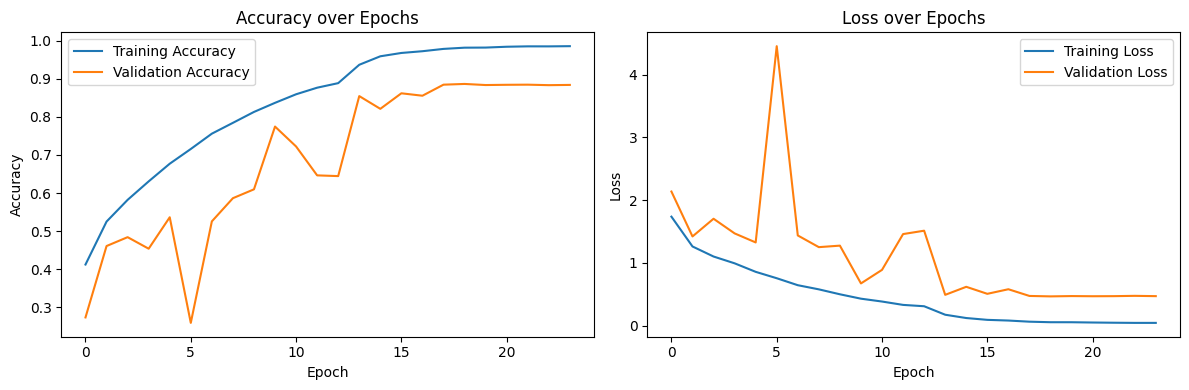

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Define callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'best_skin_cancer_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# Train the model
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop, model_checkpoint, reduce_lr],
    verbose=1
)

# Plot training history
def plot_history(history):
    plt.figure(figsize=(12, 4))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_history(history)

Test Accuracy: 0.8905
Test Loss: 0.4619
99/99 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step

Classification Report:
                            precision    recall  f1-score   support

         actinic keratosis       0.85      0.92      0.88       349
      basal cell carcinoma       0.87      0.89      0.88       349
            dermatofibroma       0.93      0.96      0.94       349
                  melanoma       0.84      0.82      0.83       349
                     nevus       0.92      0.87      0.89       349
pigmented benign keratosis       0.85      0.82      0.84       349
      seborrheic keratosis       0.88      0.93      0.91       349
   squamous cell carcinoma       0.88      0.82      0.85       349
           vascular lesion       0.99      0.99      0.99       349

                  accuracy                           0.89      3141
                 macro avg       0.89      0.89      0.89      3141
              weighted avg       0.89      0.89      0.89      3141



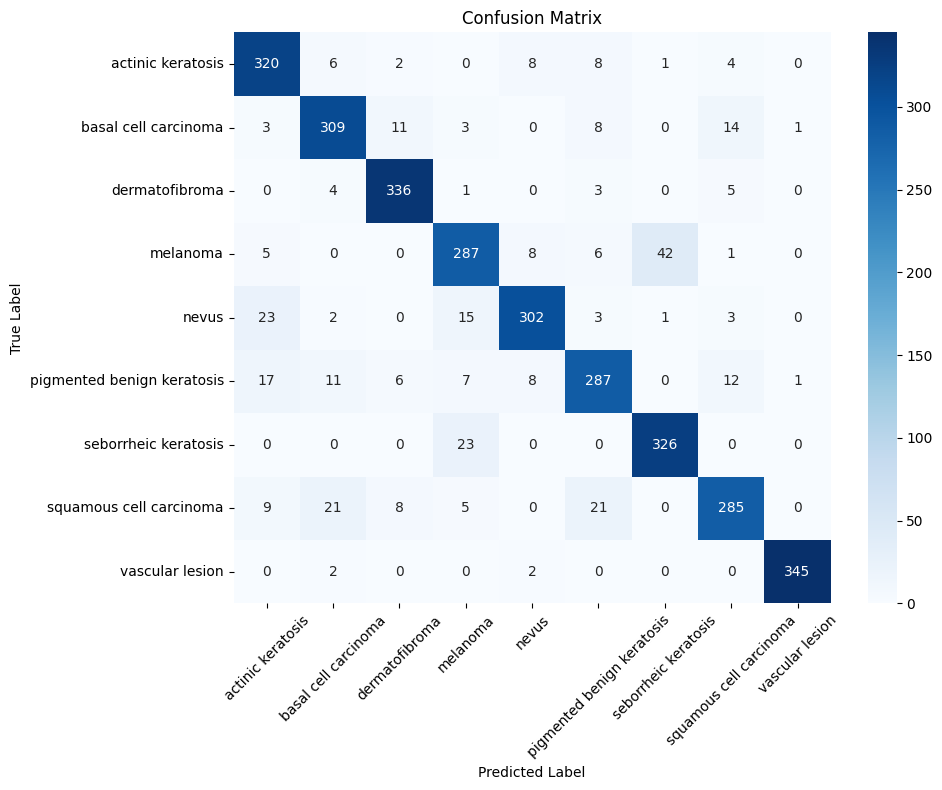

In [8]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

# Load the best model
from tensorflow.keras.models import load_model
best_model = load_model('best_skin_cancer_model.h5')

# Evaluate on test set
test_loss, test_acc = best_model.evaluate(x_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Make predictions
y_pred = best_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=list(label_map.values())))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_map.values(), yticklabels=label_map.values())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Text(0.5, 0, 'False Positive Rate')

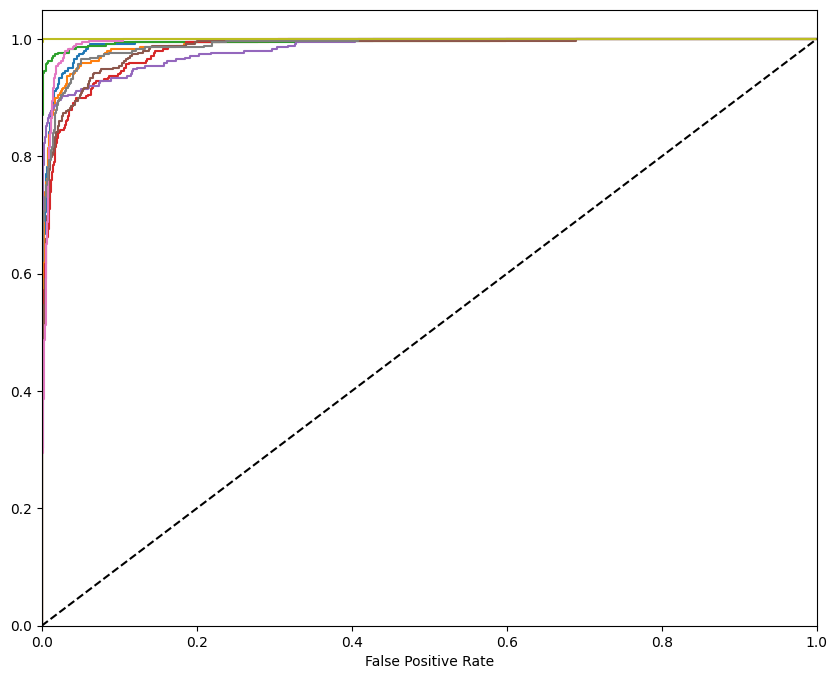

In [9]:
#ROC Curve and AUC for each class
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
# Binarize the output
y_test_binarized = label_binarize(y_true, classes=range(num_classes))
y_pred_binarized = y_pred
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_binarized[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {label_map[i]} (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')